In [1]:
import pypsa
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.patches as mpatches
import matplotlib.cm as cm

In [2]:
wd = "/home/cs/Documents/Cola/Master/MS_5-Semester/AU-Viborg"
scenarios = [1,2,3,4,5]

# Build list of filenames in desired order
files = [f"{wd}/networks/scenario_{SC}_solved.nc" for SC in scenarios]

In [12]:
n.carriers['color']

name
solar           
wind            
biogas          
CHP             
heat_storage    
heat_sink       
Name: color, dtype: object

In [15]:
# Store data for all files
all_costs = []
nrFiles = 0
count = 1

for filename in files:
    if filename.endswith('.nc'):
        n = pypsa.Network(os.path.join("../networks/solved/", filename))
        if count == 1:
            unique_carriers = all_costs_df['Carrier'].unique()
            cmap = cm.get_cmap('tab20', len(unique_carriers))
            carrier_to_color = {
                carrier: cmap(i)
                for i, carrier in enumerate(unique_carriers)
            }
            count = count + 1

        # Calculate costs
        storage_capital_costs = (n.storage_units['capital_cost'] * 
                                 (n.storage_units['p_nom_opt'] - n.storage_units['p_nom'])).groupby(n.storage_units['carrier']).sum()
        storage_marginal_costs = (n.storage_units['marginal_cost'] * 
                                  n.storage_units_t.p.sum(axis=0)).groupby(n.storage_units['carrier']).sum()
        generators_capital_costs = (n.generators['capital_cost'] * 
                                    (n.generators['p_nom_opt'] - n.generators['p_nom'])).groupby(n.generators['carrier']).sum()
        generators_marginal_costs = (n.generators['marginal_cost'] * 
                                     n.generators_t.p.sum(axis=0)).groupby(n.generators['carrier']).sum()
        link_capital_costs = n.links['capital_cost'] * (n.links['p_nom_opt']).groupby(n.links['carrier']).sum()
        link_marginal_costs = n.links['marginal_cost'] * n.links_t.p0.sum(axis=0).groupby(n.links['carrier']).sum()

        # Combine costs into a single DataFrame
        capital_costs = (
            storage_capital_costs
            .add(generators_capital_costs, fill_value=0)
            .add(link_capital_costs, fill_value=0)
        )

        marginal_costs = (
            storage_marginal_costs
            .add(generators_marginal_costs, fill_value=0)
            .add(link_marginal_costs, fill_value=0)
        )
        costs_df = pd.DataFrame({
            "Capital costs": capital_costs,
            "Marginal costs": marginal_costs
        }).T
        
        # Store costs and colors
        for carrier, row in carrier_costs.iterrows():
            for cost_type, value in row.items():
                all_costs.append({
                    'File': filename,
                    'Carrier': carrier,
                    'Cost Type': cost_type,
                    'Value': value,
                    'Color': carrier_to_color[carrier],
                    'Hatch': '///' if cost_type == 'Marginal' else None
                })
        
        nrFiles += 1

# Convert accumulated costs to a DataFrame
all_costs_df = costs_df

# Pivot the data for stacked bar chart
pivoted_costs = all_costs_df.pivot_table(
    index='File',
    columns=['Carrier', 'Cost Type'],
    values='Value',
    fill_value=0
)
# reindexing to match wanted order
pivoted_costs = pivoted_costs.loc[files]

# Calculate total costs per file for percentage calculations
total_costs_per_file = pivoted_costs.sum(axis=1)
reference_total = total_costs_per_file.iloc[0]  # First bar as reference

# Plot stacked bars
fig, ax = plt.subplots(figsize=((1*nrFiles), 4)) #(0.9*nrFiles), 4.5)
bar_width = 0.6
x = np.arange(len(pivoted_costs.index))  # One bar per file

# Store unique legend handles for capital costs
legend_handles = {}
# Iterate through carriers and cost types for stacking
y_offset = np.zeros(len(pivoted_costs.index))
for i, ((carrier, cost_type), values) in enumerate(pivoted_costs.items()):
    # Determine color and hatching
    color = all_costs_df.loc[
        (all_costs_df['Carrier'] == carrier) & (all_costs_df['Cost Type'] == cost_type),
        'Color'
    ].iloc[0]
    hatch = '///' if cost_type == 'Marginal' else None
    
    # Plot bar segment
    ax.bar(x, values, bar_width, bottom=y_offset, label=f'{carrier} {cost_type}', color=color, hatch=hatch, edgecolor='black', linewidth=0.5)
    y_offset += values  # Update offset for stacking

    # Add legend handles for capital costs only
    if cost_type == 'Capital' and carrier not in legend_handles:
        legend_handles[carrier] = mpatches.Patch(color=color, label=f'{carrier}')

# Add percentage labels above bars
for i, (idx, total_cost) in enumerate(total_costs_per_file.items()):
    if i == 0:  # First bar - show actual value
        label = f'{total_cost/1e11:.2f}'  # Convert to billions and format (B€)
    else:  # Other bars - show percentage change
        percentage_change = ((total_cost - reference_total) / reference_total) * 100
        if percentage_change >= 0:
            label = f'+{percentage_change:.1f}%'
        else:
            label = f'{percentage_change:.1f}%'
    
    # Position label above the bar
    ax.text(i, total_cost + max(total_costs_per_file) * 0.01, label, 
            ha='center', va='bottom', fontsize=9) #fontweight='bold'

# Add single hatching legend for marginal costs
marginal_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Marginal Costs')

# Add labels and legend
#ax.set_title('Stacked Bar Chart of Carrier Costs by File with Custom Colors and Hatching')
ax.set_ylabel('Total System Cost (EUR)')
ax.set_xticks(x)
ax.set_xticklabels(mods, rotation=45, ha='right')

# Adjust y-axis to accommodate labels
ax.set_ylim(0, max(total_costs_per_file) * 1.1)

# Combine handles into the legend
ax.legend(handles=list(legend_handles.values()) + [marginal_patch], 
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    alignment='left',
    frameon=False,
    handlelength=0.7,)

plt.tight_layout()
#plt.show()
#plt.savefig(f'../figures/total_system_cost_ALL.pdf', bbox_inches='tight')

INFO:pypsa.network.io:New version 1.0.3 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, storage_units, sub_networks


KeyError: 'Carrier'

INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, storage_units, sub_networks
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, storage_units, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, storage_units, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, storage_units, stores, sub_networks
INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stor

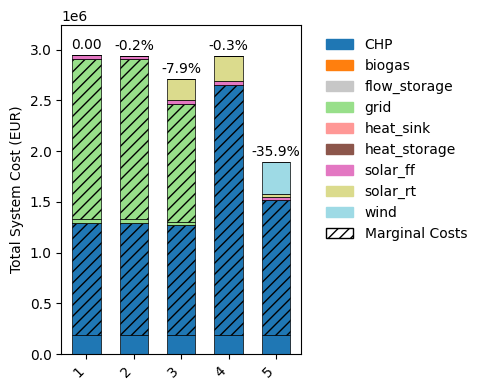

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

# --------------------------------------------------
# ACCUMULATION VARIABLES
# --------------------------------------------------
all_costs = []
nrFiles = 0

# --------------------------------------------------
# PROCESS EACH FILE
# --------------------------------------------------
processed_files = []

for filename in files:
    if filename.endswith('.nc'):
        processed_files.append(filename)

        n = pypsa.Network(os.path.join("../networks/solved/", filename))

        # CAPITAL COSTS
        storage_capital_costs = (
            n.storage_units['capital_cost'] *
            (n.storage_units['p_nom_opt'] - n.storage_units['p_nom'])
        ).groupby(n.storage_units['carrier']).sum()

        generators_capital_costs = (
            n.generators['capital_cost'] *
            (n.generators['p_nom_opt'] - n.generators['p_nom'])
        ).groupby(n.generators['carrier']).sum()

        link_capital_costs = (
            n.links['capital_cost'] *
            n.links['p_nom_opt']
        ).groupby(n.links['carrier']).sum()

        capital_costs = (
            storage_capital_costs
            .add(generators_capital_costs, fill_value=0)
            .add(link_capital_costs, fill_value=0)
        )

        # MARGINAL COSTS
        storage_marginal_costs = (
            n.storage_units['marginal_cost'] *
            n.storage_units_t.p.sum(axis=0)
        ).groupby(n.storage_units['carrier']).sum()

        generators_marginal_costs = (
            n.generators['marginal_cost'] *
            n.generators_t.p.sum(axis=0)
        ).groupby(n.generators['carrier']).sum()

        link_marginal_costs = (
            n.links['marginal_cost'] *
            n.links_t.p0.sum(axis=0)
        ).groupby(n.links['carrier']).sum()

        marginal_costs = (
            storage_marginal_costs
            .add(generators_marginal_costs, fill_value=0)
            .add(link_marginal_costs, fill_value=0)
        )

        # Combined per-carrier DataFrame
        carrier_costs = pd.DataFrame({
            "Capital": capital_costs,
            "Marginal": marginal_costs
        }).fillna(0)

        nrFiles += 1

        # --------------------------------------------------
        # STORE COST RECORDS (COLORS ASSIGNED LATER)
        # --------------------------------------------------
        for carrier, row in carrier_costs.iterrows():
            for cost_type, value in row.items():
                all_costs.append({
                    "File": filename,
                    "Carrier": carrier,
                    "Cost Type": cost_type,
                    "Value": value
                })

# --------------------------------------------------
# COMBINE ALL FILES INTO DATAFRAME
# --------------------------------------------------
all_costs_df = pd.DataFrame(all_costs)

# --------------------------------------------------
# AUTOMATIC COLOR ASSIGNMENT
# --------------------------------------------------
unique_carriers = all_costs_df['Carrier'].unique()
cmap = cm.get_cmap('tab20', len(unique_carriers))

carrier_to_color = {
    carrier: cmap(i)
    for i, carrier in enumerate(unique_carriers)
}

# Add colors to DataFrame
all_costs_df['Color'] = all_costs_df['Carrier'].map(carrier_to_color)
all_costs_df['Hatch'] = all_costs_df['Cost Type'].apply(
    lambda x: '///' if x == 'Marginal' else None
)

# --------------------------------------------------
# PIVOT FOR STACKED BAR PLOT
# --------------------------------------------------
pivoted_costs = all_costs_df.pivot_table(
    index="File",
    columns=["Carrier", "Cost Type"],
    values="Value",
    fill_value=0
)

# Ensure correct order
pivoted_costs = pivoted_costs.loc[processed_files]

total_costs_per_file = pivoted_costs.sum(axis=1)
reference_total = total_costs_per_file.iloc[0]

# --------------------------------------------------
# PLOTTING
# --------------------------------------------------
fig, ax = plt.subplots(figsize=((1*nrFiles), 4))
x = np.arange(len(processed_files))
bar_width = 0.6

y_offset = np.zeros(len(processed_files))
legend_handles = {}

for (carrier, cost_type), values in pivoted_costs.items():

    color = carrier_to_color[carrier]
    hatch = '///' if cost_type == 'Marginal' else None

    ax.bar(
        x, values,
        bar_width,
        bottom=y_offset,
        color=color,
        hatch=hatch,
        edgecolor='black',
        linewidth=0.5
    )

    y_offset += values

    if cost_type == "Capital" and carrier not in legend_handles:
        legend_handles[carrier] = mpatches.Patch(
            color=color,
            label=carrier
        )

# Percentage labels
for i, total in enumerate(total_costs_per_file):

    if i == 0:
        label = f"{total/1e11:.2f}"
    else:
        pct = (total - reference_total) / reference_total * 100
        label = f"{pct:+.1f}%"

    ax.text(i, total + 0.01*max(total_costs_per_file),
            label, ha='center', va='bottom')

# Marginal hatch legend
marginal_patch = mpatches.Patch(
    facecolor='white',
    edgecolor='black',
    hatch='///',
    label='Marginal Costs'
)

# Axes and legend
ax.set_ylabel("Total System Cost (EUR)")
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=45, ha='right')
ax.set_ylim(0, 1.1 * max(total_costs_per_file))

ax.legend(
    handles=list(legend_handles.values()) + [marginal_patch],
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    frameon=False,
)

plt.tight_layout()
plt.show()


In [7]:
n.generators.p_nom_opt

name
grid_export      2.968840e+00
solar_S_ff       8.400000e-01
solar_SE_rt      0.000000e+00
solar_S_rt       1.256834e-01
solar_SW_rt      1.326230e-01
solar_E_rt       0.000000e+00
solar_NW_rt      0.000000e+00
solar_N_rt       0.000000e+00
solar_NE_rt      0.000000e+00
solar_W_rt       0.000000e+00
wind             2.970354e+00
biogas_supply    1.000000e+12
Name: p_nom_opt, dtype: float64